In [1]:
using ITensors
using DataFrames
using CSV
using Plots

# Function of DMRG Simulation

In [2]:
# Define operators for spin 3/2
ITensors.space(::SiteType"S=3/2") = 4

ITensors.op(::OpName"Sz",::SiteType"S=3/2") =
  [+3/2   0    0    0
     0  +1/2   0    0
     0    0  -1/2   0
     0    0    0  -3/2]

ITensors.op(::OpName"S+",::SiteType"S=3/2") =
  [0  √3  0  0
   0   0  2  0
   0   0  0 √3
   0   0  0  0]

ITensors.op(::OpName"S-",::SiteType"S=3/2") =
  [0   0  0   0
   √3  0  0   0
   0   2  0   0
   0   0  √3  0]

In [3]:
# Define the site space for spin 2
ITensors.space(::SiteType"S=2") = 5

# Define the Sz operator for spin 2
ITensors.op(::OpName"Sz", ::SiteType"S=2") = [
  2  0  0  0  0
  0  1  0  0  0
  0  0  0  0  0
  0  0  0 -1  0
  0  0  0  0 -2
]

# Define the S+ operator for spin 2
ITensors.op(::OpName"S+", ::SiteType"S=2") = [
  0  2    0     0     0
  0  0   √6     0     0
  0  0    0    √6     0
  0  0    0     0     2
  0  0    0     0     0
]

# Define the S- operator for spin 2
ITensors.op(::OpName"S-", ::SiteType"S=2") = [
  0     0     0     0  0
  2     0     0     0  0
  0    √6     0     0  0
  0     0    √6     0  0
  0     0     0     2  0
]

In [4]:
function InitMPS(linkdim::Int, K::Int, WaveType::String, sites::Vector{Index{Int64}})
    # Create an array containing all the states we want to calculate 
    psi_arr = []
   
    if WaveType == "random"
       println("start with random states")
       for m = 1:K
           # Generate a random MPS
           psi_m = randomMPS(sites; linkdims = linkdim)
           # Add the new MPS to the array
           push!(psi_arr, psi_m)
       end
    else
       println("which initial states?!")
    end
    return psi_arr
end

InitMPS (generic function with 1 method)

In [5]:
function AKLT_Hamiltonian(N::Int64)

    os = OpSum() 
    for j=1:N-1 
        # S*S Terms
        # Sz Sz
        os += "Sz", j, "Sz", j+1

        # S+ S- and S- S+
        os += 1/2, "S+", j, "S-", j+1
        os += 1/2, "S-", j, "S+", j+1

        # Square terms in (S*S)^2
        # (1/3) * (Sz Sz)^2 term
        os += (1/3), "Sz", j, "Sz", j+1, "Sz", j, "Sz", j+1
        # (1/3) * (1/4) (S+ S- S+ S-) term
        os += (1/3) * (1/4), "S+", j, "S-", j+1, "S+", j, "S-", j+1
        os += (1/3) * (1/4), "S-", j, "S+", j+1, "S-", j, "S+", j+1

        # Cross terms in (S*S)^2
        # (1/3) * (1/2) Sz Sz S+ S- terms
        os += (1/3) * (1/2), "Sz", j, "Sz", j+1, "S+", j, "S-", j+1
        os += (1/3) * (1/2), "S+", j, "S-", j+1, "Sz", j, "Sz", j+1

        # (1/3) * (1/2) Sz Sz S- S+ terms
        os += (1/3) * (1/2), "Sz", j, "Sz", j+1, "S-", j, "S+", j+1
        os += (1/3) * (1/2), "S-", j, "S+", j+1, "Sz", j, "Sz", j+1

        # (1/3) * (1/4) S+ S- S- S+ terms
        os += (1/3) * (1/4), "S+", j, "S-", j+1, "S-", j, "S+", j+1
        os += (1/3) * (1/4), "S-", j, "S+", j+1, "S+", j, "S-", j+1
    end

    return os
end

AKLT_Hamiltonian (generic function with 1 method)

In [42]:
function Transverse_Field(N::Int64, J::Float64, g::Float64)
    """
    This function is used to generate Hamiltonian with Opsum of the Heisenberg model
    N: the number of sites
    J: J coupling
    """
    os = OpSum()
    for n=1:N-1
        # The Zi*Zi+1 part
        os += -4*(g/2)*(1+J), "Sx", n, "Sx", n+1
        os += -4*(g/2)*(1-J), "Sy", n, "Sy", n+1
        # The Xi 
        os += -2, "Sz", n 
    end

    # Terms for the edge
    os += -2, "Sz", N

    # Periodic Terms
    os += -4*(g/2)*(1+J), "Sx", N, "Sx", 1
    os += -4*(g/2)*(1-J), "Sy", N, "Sy", 1
    return os
end

Transverse_Field (generic function with 1 method)

In [14]:
function Heisenberg_Hamiltonian(N::Int64, J::Any)
    """
    This function is used to generate Hamiltonian with Opsum of the Heisenberg model
    N: the number of sites
    J: J coupling
    """
    os = OpSum()
    for n=1:N-1
        os += J, "Sz",n,"Sz",n+1
        os += J/2, "S+", n, "S-", n+1
        os += J/2, "S-", n, "S+", n+1
    end

    # periodic boundary conditions (PBCs)
    #os += J, "Sz",1,"Sz",N
    #os += J/2, "S+", 1, "S-", N
    #os += J/2, "S-", 1, "S+", N

    return os
end

Heisenberg_Hamiltonian (generic function with 1 method)

In [15]:
BondDims = [10, 20, 40, 60, 80, 100];
cutoff = [1e-10];
noise = [1e-7, 1e-8, 1e-10, 0, 1e-11, 1e-10, 1e-9, 1e-11, 0];

In [16]:
function Energy_DMRG(N_sites::Int64, Spin::Float64, Max_n_sweep::Int64, Max_n_State::Int64, g_param::Float64)

    # Define site according to the spin type 
    if Spin == 0.5
        psites = siteinds("S=1/2",N_sites);
    elseif Spin == 1
        psites = siteinds("S=1",N_sites);
    elseif Spin == 3/2
        psites = siteinds("S=3/2",N_sites);
    elseif Spin == 2
        psites = siteinds("S=2",N_sites);
    else
        println("Other spin model currently not available :(");
    end

    # Create a random array of MPS using the function we just defined
    psi_initials = InitMPS(10, Max_n_State, "random", psites);

    # Create a AKLT Hamiltonian MPO
    os = Transverse_Field(N_sites, 1.0, g_param);
    H = MPO(os, psites);

    # Define an observer to control the energy tolerance
    obs = DMRGObserver(["Sz"], psites, energy_tol=1E-10);

    println("Start Calculating Groud State!")

    # Use DMRG to calculate the ground state
    temp_energy, temp_psi = dmrg(H, psi_initials[1], nsweeps=Max_n_sweep, maxdim=BondDims, mindim=20, cutoff=cutoff, noise=noise, eigsolve_krylovdim=10, observer = obs);

    # Calculate the norm of optimized ground state MPS
    norm = inner(temp_psi, temp_psi)

    # Calculate the normalized ground state energy
    energy = temp_energy/norm;

    # Store the result in the energy array
    energy_array = [energy];
    psi_array = [temp_psi];

    for m = 2:Max_n_State
    println("Start Calculating the $(m-1)^th Excited State!")

    # Caculate the m^th excited state
    temp_energy, temp_psi = dmrg(H, psi_array[1:m-1], psi_initials[m]; nsweeps=Max_n_sweep, maxdim=BondDims, mindim=20, cutoff=cutoff, noise=noise, weight=10, eigsolve_krylovdim=10, observer=obs);
    norm = inner(temp_psi, temp_psi);
    energy = temp_energy/norm;

    # Store the resulting state and energy
    push!(psi_array, temp_psi);
    push!(energy_array, energy);
    end

    println("Energys are: ", energy_array)
    println("Calculation finished :3")
    return energy_array, temp_psi
end

Energy_DMRG (generic function with 1 method)

# Energy Change with Sites

In [21]:
# Initialize arrays to store results
system_sizes = 2:4:46  # Step by 2
energies_list = []

# Calculate energies for system sizes from 2 to 15
for N in system_sizes
    println("Calculating for system size N = $N")
    energies, psi = Energy_DMRG(N, 0.5, 100, 1, 0.5)
    push!(energies_list, [N; energies])
end

Calculating for system size N = 2
start with random states
Start Calculating Groud State!
After sweep 1 energy=-0.7071067811865475  maxlinkdim=2 maxerr=0.00E+00 time=0.013
After sweep 2 energy=-0.7071067811865475  maxlinkdim=2 maxerr=0.00E+00 time=0.000
After sweep 3 energy=-0.7071067811865475  maxlinkdim=2 maxerr=0.00E+00 time=0.001
Energy difference less than 1.0e-10, stopping DMRG
Energys are: [-0.7071067811865474]
Calculation finished :3
Calculating for system size N = 6
start with random states
Start Calculating Groud State!
After sweep 1 energy=-2.761014785400112  maxlinkdim=10 maxerr=1.22E-17 time=0.011
After sweep 2 energy=-2.7610147854001075  maxlinkdim=20 maxerr=0.00E+00 time=0.005
After sweep 3 energy=-2.7610147854001084  maxlinkdim=20 maxerr=1.32E-37 time=0.003
Energy difference less than 1.0e-10, stopping DMRG
Energys are: [-2.761014785400107]
Calculation finished :3
Calculating for system size N = 10
start with random states
Start Calculating Groud State!
After sweep 1 en

In [22]:
# Determine the number of excited states calculated
num_excited_states = maximum(length(e) - 2 for e in energies_list)

# Define column titles
columns = ["SystemSize", "GroundStateEnergy"]
for i in 1:num_excited_states
    push!(columns, "ExcitedStateEnergy_$i")
end

# Create a DataFrame from energies_list
data = []
for e in energies_list
    push!(data, e)
end

# Merge the title and data together
reshaped_energy_list = hcat(energies_list...)' 
df = DataFrame(reshaped_energy_list, Symbol.(columns))

Row,SystemSize,GroundStateEnergy
,Float64,Float64
1,2.0,-0.707107
2,6.0,-2.76101
3,10.0,-4.88275
4,14.0,-7.0095
5,18.0,-9.13656
6,22.0,-11.2637
7,26.0,-13.3907
8,30.0,-15.5178
9,34.0,-17.6449


In [41]:
# Export energy data
CSV.write("energies_all_states.csv", df)
println("Data exported to energies_all_states.csv :P")

Data exported to energies_all_states.csv :P


# Entanglment Entropy Change with System Size

In [43]:
function entanglement_entropy(psi::MPS, b::Int, base::Float64 = exp(1.0))
    # Orthogonalize the MPS at site b
    psi = psi / norm(psi)  # Ensure the MPS is normalized
    psi = orthogonalize(psi, b)
    
    # Perform SVD on the tensor at site b
    U, S, V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
    
    # Initialize the entanglement entropy
    SvN = 0.0
    
    # Calculate the von Neumann entropy
    for n in 1:dim(S, 1)
        p = S[n, n]^2
        if p > 1e-12 && p <= 1  # Avoid numerical issues with very small p
            SvN -= p * log(p) / log(base)  # Use the specified base for the logarithm
        end
    end
    
    return SvN
end

entanglement_entropy (generic function with 2 methods)

In [44]:
# Initialize arrays to store results
system_sizes = 36:4:72  # Step by 2
entropy_list = []
spin = 1/2
g = 1.0
base = 2.0

# Calculate energies for system sizes from 2 to 15
for N in system_sizes
    println("Calculating for system size N = $N")
    energies, psi = Energy_DMRG(N, spin, 600, 1, g)
    entropy = entanglement_entropy(psi, Int(N/2), base)
    push!(entropy_list, entropy)
end

Calculating for system size N = 36
start with random states
Start Calculating Groud State!
After sweep 1 energy=-45.7891464478211  maxlinkdim=10 maxerr=6.57E-05 time=0.177
After sweep 2 energy=-45.84947532175624  maxlinkdim=20 maxerr=4.58E-07 time=0.215
After sweep 3 energy=-45.85117111683185  maxlinkdim=40 maxerr=5.71E-10 time=0.546
After sweep 4 energy=-45.85117122544502  maxlinkdim=50 maxerr=9.95E-11 time=0.641
After sweep 5 energy=-45.8511712258921  maxlinkdim=50 maxerr=9.81E-11 time=0.654
After sweep 6 energy=-45.85117122588374  maxlinkdim=50 maxerr=9.82E-11 time=0.642
Energy difference less than 1.0e-10, stopping DMRG
Energys are: ComplexF64[-45.85117122588359 + 0.0im]
Calculation finished :3
Calculating for system size N = 40
start with random states
Start Calculating Groud State!
After sweep 1 energy=-50.91369072096254  maxlinkdim=10 maxerr=9.68E-05 time=0.101
After sweep 2 energy=-50.94252098780994  maxlinkdim=20 maxerr=3.79E-07 time=0.201
After sweep 3 energy=-50.942673837595

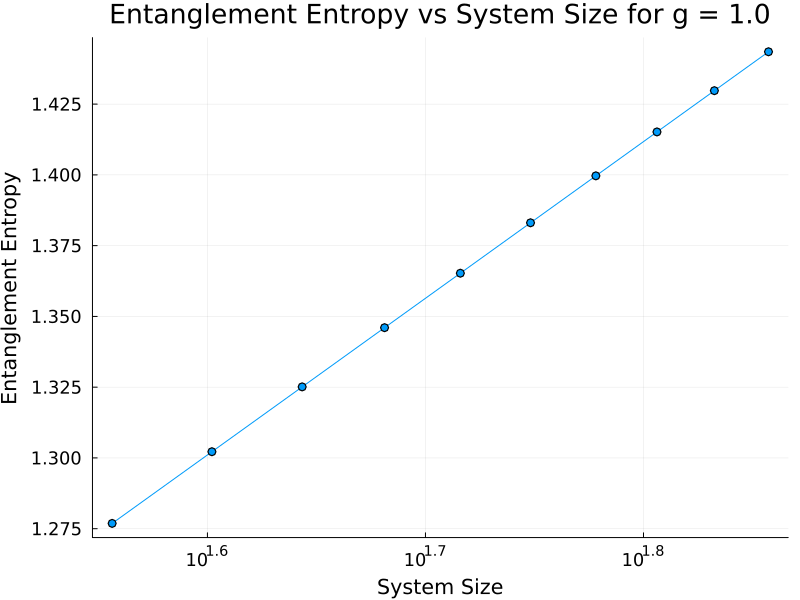

In [45]:
# Create the plot with larger size and title
plot(system_sizes, entropy_list,
     marker = :o,
     xlabel = "System Size",
     ylabel = "Entanglement Entropy",
     title = "Entanglement Entropy vs System Size for g = $g",
     legend = false,
     xscale = :log10,
     xformatter = :plain,
     titlefontsize = 18,      # Increase title font size
     guidefontsize = 14,      # Increase axis labels font size
     tickfontsize = 12,       # Increase tick labels font size
     size = (800, 600))       # Increase plot size (width x height)


In [46]:
# Create a DataFrame from the results
df = DataFrame(SystemSize = system_sizes, EntanglementEntropy = entropy_list)

# Dynamically create a file name based on the spin value
file_name = "entanglement_entropy_vs_system_size_g=$g.csv"

# Export the DataFrame to a CSV file
CSV.write(file_name, df)

"entanglement_entropy_vs_system_size_g=1.0.csv"